# Assignment - NST

## Anindya Sen (224102306), IIT, Guwahati

Neural Style Transfer (NST) leverages a pre-trained convolutional neural network, exemplifying the concept of transfer learning, where a network trained on a very large dataset for one task is repurposed for another. We will define our cost functions and use the pretrained CNN as a pattern extractor.

In this case, we will train our own feature extractor base model. The referance is [original NST paper](https://arxiv.org/abs/1508.06576) published in 2014.

# **Importing necessary libraries**

In [1]:
import os
import cv2
import shutil, random
import tensorflow as tf
import keras.preprocessing.image as process_im
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot
import matplotlib.gridspec as gridspec
import functools
import IPython.display


Using TensorFlow backend.


In [4]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'glacier': #Folder contain Glacier Images get the '2' class label.
            label = 2
        elif labels == 'sea':
            label = 4
        elif labels == 'buildings':
            label = 0
        elif labels == 'forest':
            label = 1
        elif labels == 'street':
            label = 5
        elif labels == 'mountain':
            label = 3
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            image = image/255.0
            image = cv2.resize(image,(150,150)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=2) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]

In [5]:
Images, Labels = get_images('/kaggle/input/intel-image-classification/seg_train/seg_train/') 
Images = np.array(Images) #converting the list of images to numpy array.
Labels = np.array(Labels)
print(Images.shape, Labels.shape)

(14034, 150, 150, 3) (14034,)


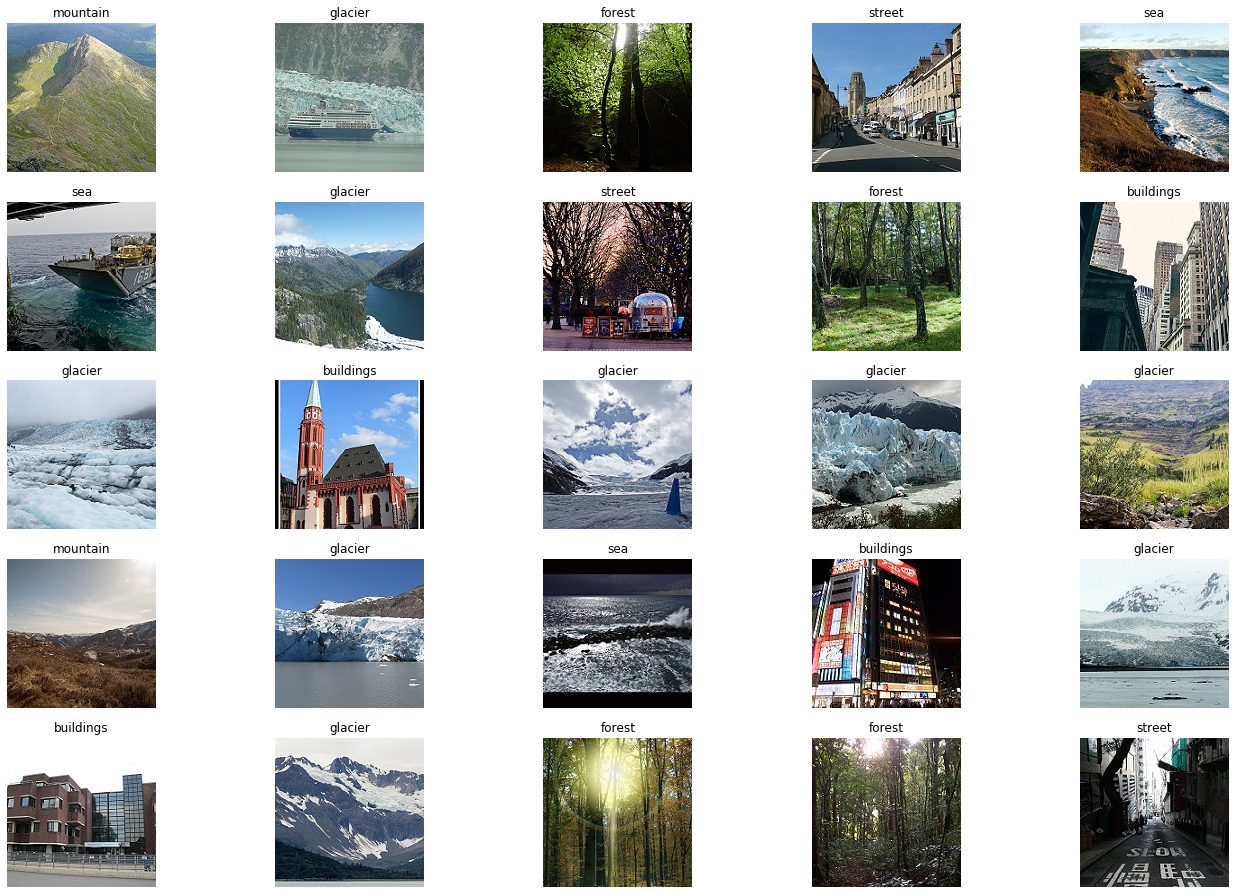

In [5]:
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = random.randint(0,len(Images))
        ax[i,j].imshow(Images[rnd_number])
        ax[i,j].set_title(get_classlabel(Labels[rnd_number]))
        ax[i,j].axis('off')

In [14]:
del Images, Labels

Let us now define our datagenerators for training, as there are huge number of images. So we can safely delete the previous arrays.

In [31]:
def data_generator(image_directory, batch_size, target_size=(150, 150), validation_split=0.2):
    datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,  # Rescale pixel values to the range [0, 1]
        validation_split=validation_split  # Split the data into training and validation
    )

    train_generator = datagen.flow_from_directory(
        image_directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',  # Use categorical labels
        subset='training',  # Specify the subset as 'training' for training data
        seed=42,
        shuffle=True
    )

    val_generator = datagen.flow_from_directory(
        image_directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',  # Use categorical labels
        subset='validation',  # Specify the subset as 'validation' for validation data
        seed=42,
        shuffle=True
    )

    return train_generator, val_generator


# Example usage:
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train/'
batch_size = 32
train_generator, val_generator = data_generator(train_dir, batch_size=batch_size)


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [34]:
model = Sequential()

# Block 1
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding = "same", input_shape=(150, 150, 3), name='block1_conv1'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding = "same", name='block1_conv2'))
model.add(MaxPooling2D(2, 2, name='block1_maxpool'))

# Block 2
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding = "same", name='block2_conv1'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding = "same", name='block2_conv2'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding = "same", name='block2_conv3'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding = "same", name='block2_conv4'))
model.add(MaxPooling2D(2, 2, name='block2_maxpool'))

# Block 3
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding = "same", name='block3_conv1'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding = "same", name='block3_conv2'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding = "same", name='block3_conv3'))
model.add(MaxPooling2D(2, 2, name='block3_maxpool'))

# Global Average Pooling and Fully Connected Layers
model.add(GlobalAveragePooling2D(name='global_average_pooling'))
model.add(Dropout(rate=0.3, name='dropout1'))
model.add(Dense(128, activation='relu', name='dense_1'))
model.add(Dropout(rate=0.3, name='dropout2'))
model.add(Dense(64, activation='relu', name='dense_2'))
model.add(Dense(6, activation='softmax', name='output'))

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 128)     3584      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block1_maxpool (MaxPooling2D (None, 75, 75, 128)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 256)       295168    
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 256)       590080    
_________________________________________________________________
block2_conv3 (Conv2D)        (None, 75, 75, 256)       590080    
_________________________________________________________________
block2_conv4 (Conv2D)        (None, 75, 75, 256)      

In [35]:
num_epochs = 50  # Adjust the number of epochs as needed

history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
)


Train for 351 steps, validate for 88 steps
Epoch 1/50
351/351 [==============================] - 78s 223ms/step - loss: 1.4387 - accuracy: 0.3574 - val_loss: 1.0823 - val_accuracy: 0.5146
Epoch 2/50
351/351 [==============================] - 77s 219ms/step - loss: 1.1044 - accuracy: 0.5062 - val_loss: 0.9482 - val_accuracy: 0.5603
Epoch 3/50
351/351 [==============================] - 77s 219ms/step - loss: 0.9943 - accuracy: 0.5513 - val_loss: 0.8713 - val_accuracy: 0.6352
Epoch 4/50
351/351 [==============================] - 77s 220ms/step - loss: 0.9381 - accuracy: 0.5882 - val_loss: 0.8472 - val_accuracy: 0.6437
Epoch 5/50
351/351 [==============================] - 77s 219ms/step - loss: 0.8404 - accuracy: 0.6548 - val_loss: 0.7955 - val_accuracy: 0.7143
Epoch 6/50
351/351 [==============================] - 77s 219ms/step - loss: 0.7641 - accuracy: 0.7052 - val_loss: 0.6273 - val_accuracy: 0.7739
Epoch 7/50
351/351 [==============================] - 77s 220ms/step - loss: 0.6891 - a

In [38]:
# model.save('/kaggle/working/my_model.keras')

In [2]:
base_model = tf.keras.models.load_model('/kaggle/working/my_model.keras')

In [ ]:
plot.plot(trained.history['acc'])
plot.plot(trained.history['val_acc'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

In [143]:
content_path='/kaggle/input/tamil-nst/TamilContentImages/C_image8.jpg'
style_path = '/kaggle/input/tamil-nst/TamilStyleImages/S_image5.jpg'

**Define function to load images and return numpy array**

In [144]:
def load_file(image_path):
    image =  Image.open(image_path)
    max_dim=512
    factor=max_dim/max(image.size)
    image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)
    im_array = process_im.img_to_array(image)
    im_array = np.expand_dims(im_array,axis=0) #for a batch of images
    return im_array

In [145]:
content = load_file(content_path)
style = load_file(style_path)

**Define function to plot image**

In [146]:
def show_im(img,title=None):
    img=np.squeeze(img,axis=0)
    plt.imshow(np.uint8(img))
    plt.axis("off")
    if title is None:
        pass
    else:
        plt.title(title)
    plt.imshow(np.uint8(img))

**Plot Image**

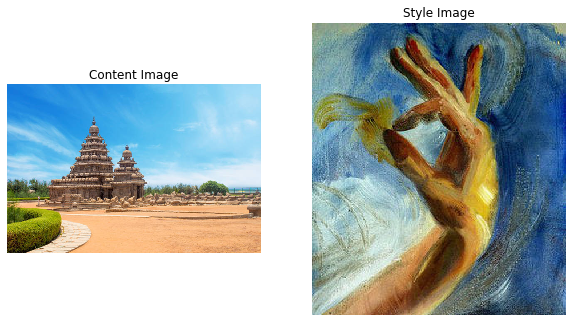

In [147]:
plt.figure(figsize=(10,10))
content = load_file(content_path)
style = load_file(style_path)
plt.subplot(1,2,1)
show_im(content,'Content Image')
plt.subplot(1,2,2)
show_im(style,'Style Image')
plt.show()

**Define function to process image for input to vgg19 model**

In [148]:
def img_preprocess(img_path):
    image=load_file(img_path)
    img=tf.keras.applications.vgg19.preprocess_input(image)
    return img

In [149]:
def rev_process_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3 #Input dimension must be [1, height, width, channel] or [height, width, channel
    mini = x.min()
    maxi = x.max()
    x = (x-mini)/(maxi-mini)
    x = x*255.0
    x = np.clip(x, 0, 255).astype('uint8')
    x = cv2.cvtColor(x, cv2.COLOR_RGB2BGR)
    return x

In [150]:
im=img_preprocess(content_path)

**Get necessary layers from base model**

In [151]:
content_layers = ['block3_conv3']
style_layers = ['block1_conv1',
                'block2_conv2',
                'block2_conv4', 
                'block3_conv2']
number_content=len(content_layers)
number_style =len(style_layers)

**Define function to get model with pretrained weights**

In [152]:
def get_model(model):
    model.trainable=False
    content_output=[model.get_layer(layer).output for layer in content_layers]
    style_output=[model.get_layer(layer).output for layer in style_layers]
    model_output= style_output+content_output
    return Model(model.input,model_output)

**Model architecture**

In [153]:
transfer_model=get_model(base_model)
transfer_model.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1_input (InputLay [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 128)     3584      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block1_maxpool (MaxPooling2D (None, 75, 75, 128)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 256)       295168    
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 256)       590080    
_________________________________________________________________
block2_conv3 (Conv2D)        (None, 75, 75, 256)       590

# **Loss Functions**

- First, we will construct the content loss function $J_{\text{content}}(C,G)$.
- Second, we will develop the style loss function $J_{\text{style}}(S,G)$.
- Finally, we'll combine these to formulate $J(G) = \alpha J_{\text{content}}(C,G) + \beta J_{\text{style}}(S,G)$.

(G - generated image, C - content image, S - Style image)

**Content Loss**

Content loss is essentially the calculation of the root mean squared error (RMSE) between the activations from both the generated and content images.

In [154]:
def get_content_loss(noise,target):
    loss = tf.reduce_mean(tf.square(noise-target))
    return loss

**Style Loss**

Our aim here is to derive style matrices for both the generated and style images. Style loss is then quantified as the root mean square difference between these matrices. This measure of style hinges on the correlation level among feature maps within a layer. Subsequently, the loss represents the disparity in correlation among feature maps as produced by both the generated and style images. Utilization of the Gram matrix enables the assessment of correlation within feature maps from a convolutional layer.

In [155]:
def gram_matrix(tensor):
    channels=int(tensor.shape[-1])
    vector=tf.reshape(tensor,[-1,channels])
    n=tf.shape(vector)[0]
    gram_matrix=tf.matmul(vector,vector,transpose_a=True)
    return gram_matrix/tf.cast(n,tf.float32)

In [156]:
def get_style_loss(noise,target):
    gram_noise=gram_matrix(noise)
    #gram_target=gram_matrix(target)
    loss=tf.reduce_mean(tf.square(target-gram_noise))
    return loss
    

In [157]:
def get_features(model,content_path,style_path):
    content_img=img_preprocess(content_path)
    style_image=img_preprocess(style_path)
    
    content_output=model(content_img)
    style_output=model(style_image)
    
    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]]
    return content_feature,style_feature
    

**Total loss**

In [158]:
def compute_loss(model, loss_weights,image, gram_style_features, content_features):
    style_weight,content_weight = loss_weights #style weight and content weight are user given parameters
                                               #that define what percentage of content and/or style will be preserved in the generated image
    
    output=model(image)
    content_loss=0
    style_loss=0
    
    noise_style_features = output[:number_style]
    noise_content_feature = output[number_style:]
    
    weight_per_layer = 1.0/float(number_style)
    for a,b in zip(gram_style_features,noise_style_features):
        style_loss+=weight_per_layer*get_style_loss(b[0],a)
        
    
    weight_per_layer =1.0/ float(number_content)
    for a,b in zip(noise_content_feature,content_features):
        content_loss+=weight_per_layer*get_content_loss(a[0],b)
        
    style_loss *= style_weight
    content_loss *= content_weight
    
    total_loss = content_loss + style_loss
    
    
    return total_loss,style_loss,content_loss

**Calculate gradient for optimization**

In [159]:
def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss=compute_loss(**dictionary)
        
    total_loss=all_loss[0]
    return tape.gradient(total_loss,dictionary['image']),all_loss

In [160]:
def run_style_transfer(base_model, content_path, style_path, epochs=500, content_weight=1e5, style_weight=1e-1):
    
    # Initialize the model and set layers to non-trainable
    style_model = get_model(base_model)
    for layer in style_model.layers:
        layer.trainable = False

    # Extract content and style features
    features_content, features_style = get_features(style_model, content_path, style_path)
    gram_matrices_style = [gram_matrix(feature) for feature in features_style]

    # Prepare the initial noise image
    initial_noise = img_preprocess(content_path)
    noise_image = tf.Variable(initial_noise, dtype=tf.float32)

    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=10, beta_1=0.99, epsilon=1e-1)

    optimal_loss = float('inf')
    optimal_image = None

    # Loss weights and parameters dictionary
    weights = (style_weight, content_weight)
    params = {'model': style_model, 'loss_weights': weights, 'image': noise_image, 
              'gram_style_features': gram_matrices_style, 'content_features': features_content}

    # Normalization parameters
    normalization_means = np.array([103.939, 116.779, 123.68])
    lower_bound = -normalization_means
    upper_bound = 255 - normalization_means

    # Initialize lists to store losses
    total_losses = []
    style_losses = []
    content_losses = []

    # List to store images for visualization
    generated_images = []
    for epoch in range(epochs):
        gradients, losses = compute_grads(params)
        total_loss, loss_style, loss_content = losses
        adam_optimizer.apply_gradients([(gradients, noise_image)])
        
        # Clipping the noise image and updating
        clipped_image = tf.clip_by_value(noise_image, lower_bound, upper_bound)
        noise_image.assign(clipped_image)

        total_losses.append(total_loss.numpy())
        style_losses.append(loss_style.numpy())
        content_losses.append(loss_content.numpy())
   
        
        optimal_image = rev_process_img(noise_image.numpy())

        # Visualization and logging
        if epoch % 100 == 0:
            visualized_image = rev_process_img(noise_image.numpy())
            generated_images.append(visualized_image)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(visualized_image))
            print(f'Epoch: {epoch}')        
            print(f'Total loss: {total_loss:.4e}, Style loss: {loss_style:.4e}, Content loss: {loss_content:.4e}')

    # Clear output and return the results
    IPython.display.clear_output(wait=True)
    return optimal_image, optimal_loss, generated_images, (total_losses, style_losses, content_losses)


# **Visualizations**

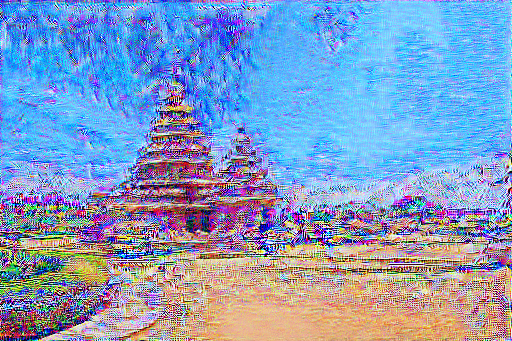

Epoch: 1000
Total loss: 1.1640e+06, Style loss: 1.7444e+04, Content loss: 1.1465e+06


In [161]:
epochs = 1001
best, best_loss, image, (total_losses, style_losses, content_losses) = \
                      run_style_transfer(base_model, content_path, style_path, epochs=epochs)

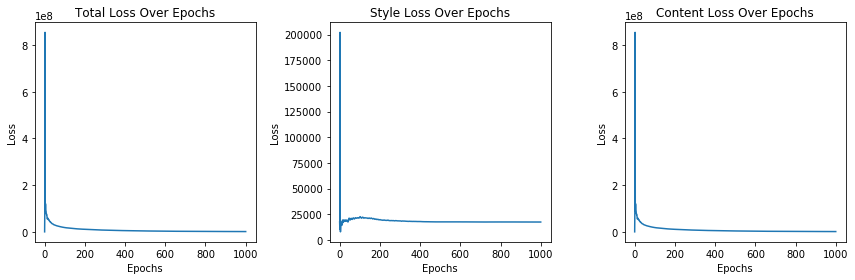

In [162]:
# Plotting the learning curves
epochs_range = range(epochs)
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, total_losses, label='Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Total Loss Over Epochs')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, style_losses, label='Style Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Style Loss Over Epochs')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, content_losses, label='Content Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Content Loss Over Epochs')

plt.tight_layout()
plt.show()

## Example 1

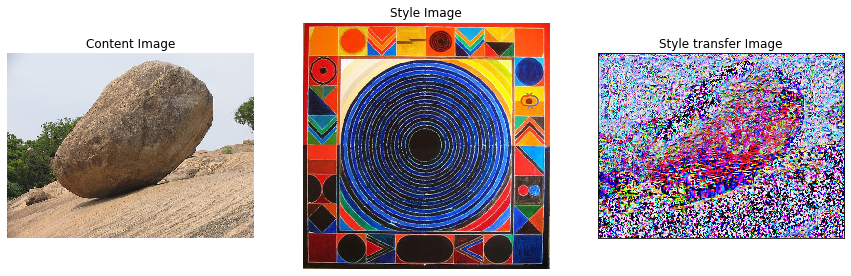

In [142]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,3)
plt.imshow(best)
plt.title('Style transfer Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,1)
show_im(content,'Content Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
show_im(style,'Style Image')
plt.xticks([])
plt.yticks([])
plt.show()

## Example 2

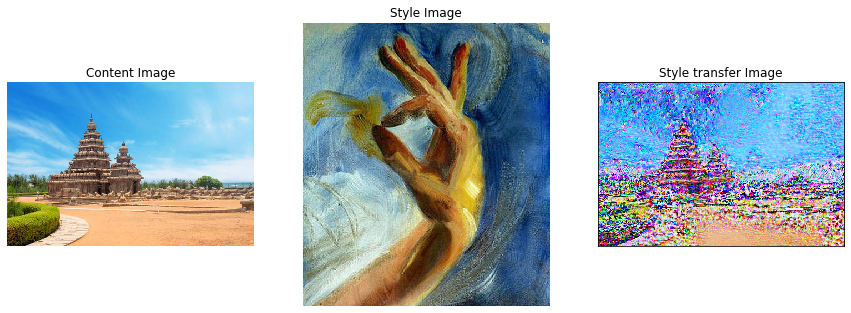

In [163]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,3)
plt.imshow(best)
plt.title('Style transfer Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,1)
show_im(content,'Content Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
show_im(style,'Style Image')
plt.xticks([])
plt.yticks([])
plt.show()